In [6]:
"""

Integrated Gradients note book for VRDU models

"""

'\n\nIntegrated Gradients note book for VRDU models\n\n'

Interpretability-for-VRDU-models  sample_data


In [2]:
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

fatal: destination path 'Interpretability-for-VRDU-models' already exists and is not an empty directory.


In [3]:
!git -C Interpretability-for-VRDU-models pull

Already up to date.


In [6]:
import sys, pathlib
sys.path.append("Interpretability-for-VRDU-models")
import vrdu_utils

In [6]:
!pip uninstall torch torchvision torchaudio fastai -y
!pip uninstall datasets transformers evaluate captum seqeval -y

!pip install torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install datasets==3.4.0 transformers==4.38.2 evaluate==0.4.0 seqeval==1.2.2 captum==0.8.0

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl (768.5 MB)
Using cached https://download.pytorch.org/whl/c

  Using cached datasets-3.4.0-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.38.2-py3-none-any.whl.metadata (130 kB)
  Using cached evaluate-0.4.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py) ... done
  Using cached captum-0.8.0-py3-none-any.whl.metadata (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 118.8 MB/s eta 0:00:00
  Created wheel for s

In [1]:
from PIL import Image, ImageDraw, ImageFont
import evaluate
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification, set_seed
from datasets import load_dataset
import transformers as t
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


set_seed(0)


In [2]:
funsd = load_dataset("nielsr/funsd")
labels = funsd["train"].features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2id = {v: k for k, v in enumerate(labels)}
print(id2label)
print(label2id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd.py:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}
{'O': 0, 'B-HEADER': 1, 'I-HEADER': 2, 'B-QUESTION': 3, 'I-QUESTION': 4, 'B-ANSWER': 5, 'I-ANSWER': 6}


In [3]:
model = LayoutLMv3ForTokenClassification.from_pretrained("adamadam111/layoutlmv3-finetuned-funsd", torch_dtype=torch.float16).to(device).eval()
try:
  processor = AutoProcessor.from_pretrained("adamadam111/layoutlmv3-finetuned-funsd")
  print("[Processor] - Loaded processor from 'adamadam111'")
except:
  processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
  print("[Processor] - Loaded processor from 'microsoft'")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

[Processor] - Loaded processor from 'microsoft'


In [4]:
for name, module in model.named_modules():
    if 'embed' in name:
        print(name)

layoutlmv3.embeddings
layoutlmv3.embeddings.word_embeddings
layoutlmv3.embeddings.token_type_embeddings
layoutlmv3.embeddings.LayerNorm
layoutlmv3.embeddings.dropout
layoutlmv3.embeddings.position_embeddings
layoutlmv3.embeddings.x_position_embeddings
layoutlmv3.embeddings.y_position_embeddings
layoutlmv3.embeddings.h_position_embeddings
layoutlmv3.embeddings.w_position_embeddings
layoutlmv3.patch_embed
layoutlmv3.patch_embed.proj


In [7]:
sample = funsd["test"][0]

enc = processor(
    Image.open(sample["image_path"]).convert("RGB"),
    sample["words"],
    boxes=sample["bboxes"],
    word_labels=sample["ner_tags"],
    padding="max_length",
    return_tensors = 'pt'
).to(device)
token_to_word = enc.word_ids(batch_index=0)
enc = vrdu_utils.to_fp16(enc, device)

with torch.no_grad():
  out = model(**enc)

pred_ids = out.logits.argmax(-1).squeeze()
print(len(pred_ids))
question_label_id = model.config.label2id["B-QUESTION"]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


512


In [8]:
question_token_idx = (pred_ids == question_label_id).nonzero(as_tuple=True)[0]
print(question_token_idx[0].item())

1


In [9]:
def token_logit_forward(input_ids, bbox, pixel_values, attention_mask, token_index):
  logits = model(input_ids = input_ids,
                 bbox=bbox,
                 pixel_values=pixel_values,
                 attention_mask=attention_mask).logits

  return logits[:, token_index, question_label_id]

def token_logit_bbox_forward(bbox,input_ids, pixel_values, attention_mask, token_index):
  logits = model(input_ids = input_ids,
                 bbox=bbox,
                 pixel_values=pixel_values,
                 attention_mask=attention_mask).logits

  return logits[:, token_index, question_label_id]

In [10]:
from captum.attr import LayerIntegratedGradients
lig = LayerIntegratedGradients(token_logit_bbox_forward, model.layoutlmv3.embeddings)

In [12]:
print(question_token_idx)

tensor([  1,   2,   3,   4,  10,  11,  68,  69,  83,  84,  88,  89, 100, 101,
        125, 126, 134], device='cuda:0')


In [21]:
print(enc["bbox"].shape)
print(zero_bbox)

torch.Size([1, 512, 4])
tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         ...,
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], device='cuda:0')


In [11]:
from tqdm import tqdm
attributions = {}
### CHANGED TO IG W.R.T BBOXES!!
zero_bbox = enc["bbox"].clone()
zero_bbox[:] = 0
zero_bbox = zero_bbox.to(device)

pad_ids = enc["input_ids"].clone()
pad_ids[:] = processor.tokenizer.pad_token_id
pad_ids = pad_ids.to(device)

for idx in question_token_idx.tolist():
  attrs, delta = lig.attribute(
      inputs = enc["bbox"],
      baselines = zero_bbox,
      additional_forward_args = (enc["input_ids"], enc["pixel_values"], enc["attention_mask"], idx),
      n_steps = 50,
      internal_batch_size = 4,
      return_convergence_delta = True)


  attributions[idx] = attrs.sum(-1).squeeze().detach().cpu()

In [43]:
print(len(attributions[3]))

512


## Attributions Investigation

### Aggregate sub word attributions to words

In [29]:
inp_ids = enc["input_ids"].squeeze()
print(token_to_word)
id2token = [tok.lstrip("Ġ") for tok in processor.tokenizer.convert_ids_to_tokens(inp_ids)] # Convert ids to tokens, strip prefix

[None, 0, 0, 1, 1, 1, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 8, 9, 10, 11, 11, 12, 13, 13, 14, 14, 15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 21, 22, 23, 23, 24, 25, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 33, 33, 34, 34, 35, 36, 36, 36, 37, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 41, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 46, 46, 47, 47, 48, 49, 49, 50, 50, 51, 52, 52, 52, 53, 54, 55, 56, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 65, 65, 65, 65, 66, 67, 68, 69, 70, 70, 70, 71, 72, 73, 74, 74, 75, 75, 75, 75, 76, 77, 77, 78, 78, 78, 79, 80, 80, 81, 82, 82, 82, 83, 84, 84, 84, 84, 85, 86, 86, 87, 88, 89, 90, 91, 92, 93, 93, 93, 93, 94, 95, 95, 96, 97, 97, 98, 99, 100, 100, 100, 100, 101, 102, 103, 103, 104, 105, 106, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 109, 110, 110, 110, 111, 112, 112, 112, 112, 113, 114, 114, 115, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128

In [30]:
for target_idx, token_ig in attributions.items():
  word_score = {}
  for tok_idx, word_idx in enumerate(token_to_word):
    if word_idx is None:
      continue
    word_score[word_idx] = word_score.get(word_idx, 0.0) + token_ig[tok_idx].item()

print(word_score)

{0: 0.24461375921964645, 1: 0.3941399082541466, 2: -0.04339843988418579, 3: -0.05085548758506775, 4: 0.0009598637698218226, 5: 0.01726210815832019, 6: -0.00385960447601974, 7: -0.00825073616579175, 8: 0.01177293702494353, 9: -0.005007357802242041, 10: -0.0012305215932428837, 11: -0.009040548233315349, 12: -0.00865985918790102, 13: -0.032350352965295315, 14: -0.02309598494321108, 15: 0.007852531969547272, 16: 0.0007449416443705559, 17: -0.00031853606924414635, 18: -0.010921876062639058, 19: 0.018679634667932987, 20: -0.009602844715118408, 21: 0.022395016625523567, 22: 0.01887168362736702, 23: -0.002883537206798792, 24: 0.020252609625458717, 25: 0.01741626689909026, 26: 0.14403048530220985, 27: 0.054012106731534004, 28: 0.015123534947633743, 29: -0.006384572712704539, 30: 0.05610855855047703, 31: 0.022328174207359552, 32: 0.012913521495647728, 33: 0.01715377112850547, 34: 0.054920539259910583, 35: -0.01457076333463192, 36: 0.04804659262299538, 37: -0.0012524316553026438, 38: -0.021516719

In [31]:
for idx, att in attributions.items():
  target_token = processor.tokenizer.decode(inp_ids[idx])
  top_pos_att_idx = torch.argmax(att).item()
  top_neg_att_idx = torch.argmin(att).item()
  print("-"*15)
  print(f"Target Token: {target_token}")
  print(f"Top Positive Attributing Token: {id2token[top_pos_att_idx]} {att[top_pos_att_idx]}")
  print(f"Top Negatve Attributing Token: {id2token[top_neg_att_idx]} {att[top_neg_att_idx]}")


---------------
Target Token:  TO
Top Positive Attributing Token: TO 0.46656936407089233
Top Negatve Attributing Token: 3 -0.11745575815439224
---------------
Target Token: :
Top Positive Attributing Token: : 0.40566766262054443
Top Negatve Attributing Token: IAL -0.1448677033185959
---------------
Target Token:  D
Top Positive Attributing Token: D 3.613839626312256
Top Negatve Attributing Token: 3 -0.17952951788902283
---------------
Target Token: ATE
Top Positive Attributing Token: ATE 1.4349335432052612
Top Negatve Attributing Token: ax -0.05124545842409134
---------------
Target Token:  NOTE
Top Positive Attributing Token: NOTE 3.3756542205810547
Top Negatve Attributing Token: 3 -0.18472126126289368
---------------
Target Token: :
Top Positive Attributing Token: : 1.821535587310791
Top Negatve Attributing Token: IAL -0.16971154510974884
---------------
Target Token:  FA
Top Positive Attributing Token: FA 2.623518943786621
Top Negatve Attributing Token: COVER -0.5316285490989685
---

### Global question heatmap

*   Aggregate ig scores across all question tokens
*   display overlay on sample image

In [12]:
global_word_score = {}

for ques_token in attributions.values():
  for tok_idx, w_idx in enumerate(token_to_word):
    if w_idx is None:
      continue
    global_word_score[w_idx] = (
        global_word_score.get(w_idx, 0.0) +
        ques_token[tok_idx].item()
    )

print(global_word_score)

{0: 2.8120488403365016, 1: 7.193411428015679, 2: -1.2206533327698708, 3: 0.5008469747845083, 4: 8.707886813092045, 5: -0.13390369981061667, 6: -0.3886856948956847, 7: -0.13521007919916883, 8: 0.40137987746857107, 9: -0.1498890658840537, 10: 0.04002443084027618, 11: -0.27439325978048146, 12: -0.22691346146166325, 13: -0.48212632234208286, 14: -0.4578204245772213, 15: -0.11735848779790103, 16: 0.07857933978084475, 17: 0.1082050979603082, 18: -0.048802145291119814, 19: 0.19713655958184972, 20: -0.25397487124428153, 21: 0.0328185735270381, 22: 0.22253478225320578, 23: -0.01634266640758142, 24: 0.275182151934132, 25: -5.240982070856262, 26: -0.8425952640827745, 27: -1.3913956652395427, 28: -0.7103099436499178, 29: -0.9021443899255246, 30: 0.4552933535305783, 31: 1.4767038056161255, 32: 5.430692907539196, 33: 5.849009350407869, 34: 5.415726905222982, 35: 0.7990622133947909, 36: 0.3352800449356437, 37: 0.16645108815282583, 38: -0.9486522465012968, 39: 1.7814213100355119, 40: 2.662325400160625

Normalize for colouring

In [33]:
def px_box_of(word_idx):
    w,h = page.size
    scale = [w/1000, h/1000, w/1000, h/1000]
    bx = sample["bboxes"][word_idx]
    return tuple(int(b*s) for b,s in zip(bx, scale))

In [34]:
max_score = max(global_word_score.values())
for w in global_word_score:
    global_word_score[w] /= max_score

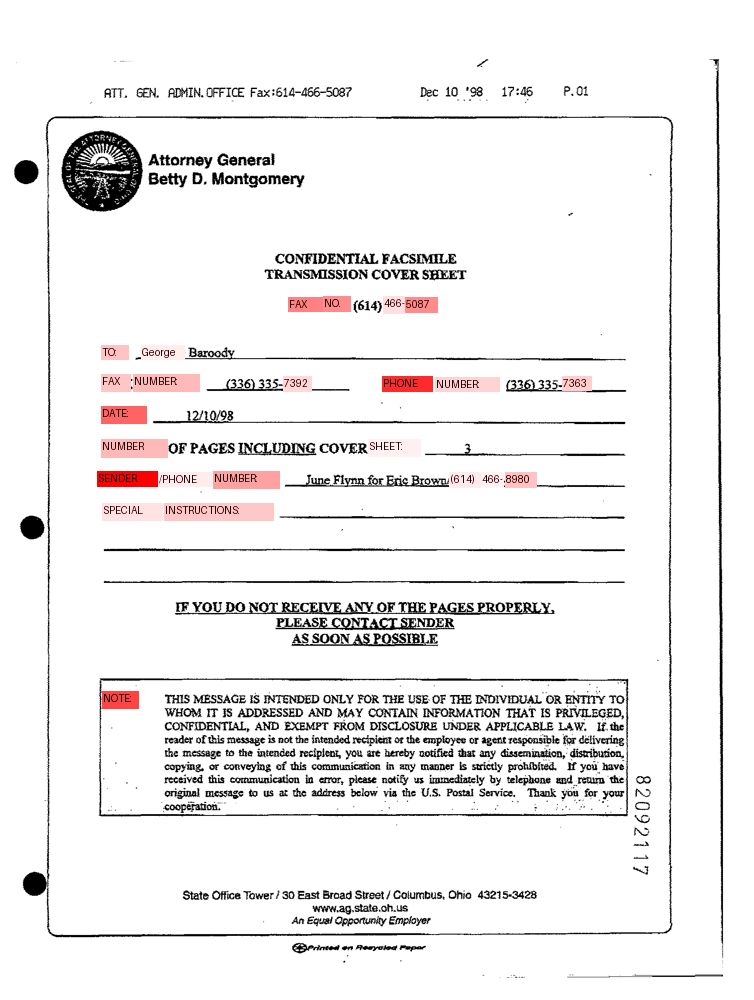

In [35]:
from PIL import Image, ImageDraw

page   = Image.open(sample["image_path"]).convert("RGBA")
draw   = ImageDraw.Draw(page, "RGBA")
w, h   = page.size
scale  = [w/1000, h/1000, w/1000, h/1000]   # LayoutLM boxes → px

for w_idx, score in global_word_score.items():
    if score < 0.05:                        # hide low-importance words
        continue
    box = sample["bboxes"][w_idx]           # FUNSD box in 0-1000 coords
    px_box = tuple(int(b*s) for b, s in zip(box, scale))
    alpha = int(255 * score)                # deeper red ↔ higher score
    draw.rectangle(px_box, fill=(255, 0, 0, alpha))
    draw.text((px_box[0]+1, px_box[1]+1), sample["words"][w_idx],
          fill=(0,0,0,255))
page

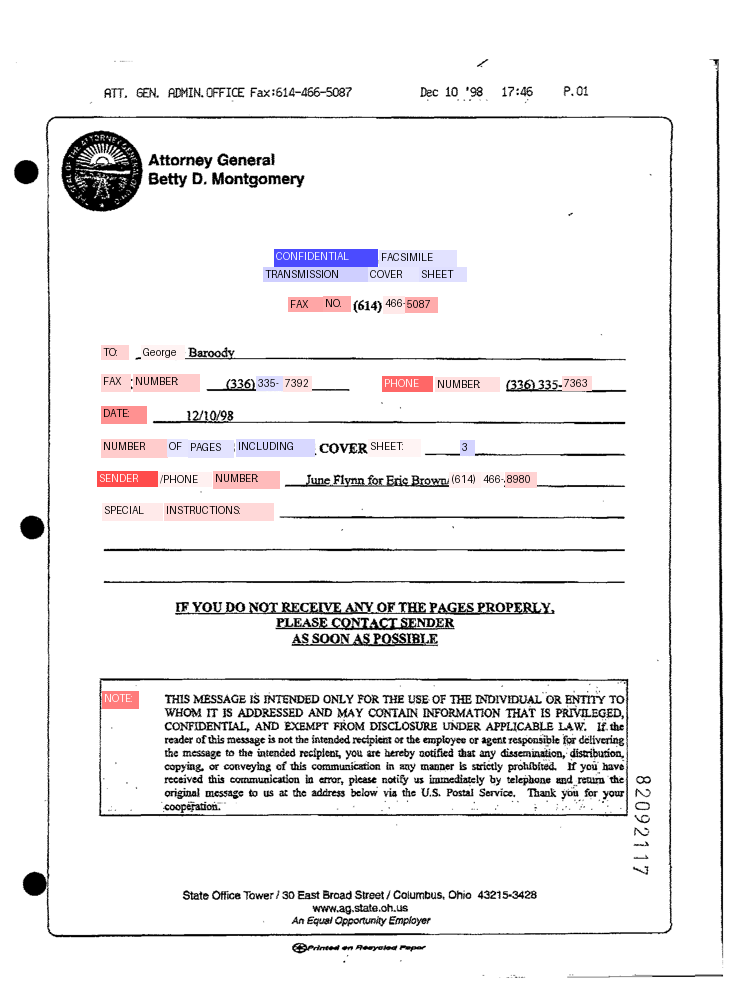

In [36]:
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps
draw = ImageDraw.Draw(page, "RGBA")          # fresh canvas

vals = list(global_word_score.values())
lo, hi = min(vals), max(vals)

if lo < 0 < hi:                              # mixed signs → diverging
    norm = colors.TwoSlopeNorm(vmin=lo, vcenter=0, vmax=hi)
    cmap = colormaps["bwr"]                  # blue-white-red
else:                                        # all same sign
    norm = colors.Normalize(vmin=lo, vmax=hi)
    cmap = colormaps["Reds"] if hi > 0 else colormaps["Blues_r"]

threshold = 0.05 * max(abs(lo), abs(hi))         # 5 % cut-off
alpha     = 180                                  # constant transparency

for w_idx, score in global_word_score.items():
    if abs(score) < threshold:
        continue
    box = px_box_of(w_idx)

    r, g, b, _ = cmap(norm(score))
    rgba = (int(255*r), int(255*g), int(255*b), alpha)
    draw.rectangle(box, fill=rgba)

    # decide black or white text by luminance of rectangle colour
    luminance = 0.299*r + 0.587*g + 0.114*b
    txt_colour = (0,0,0,255) if luminance > 0.5 else (255,255,255,255)

    draw.text((box[0]+2, box[1]+1), sample["words"][w_idx],fill=txt_colour)
page